# GPU Accelerated data manipulation

cuDF is the RAPIDS API that enables you to create and manipulate GPU-accelerated dataframes. cuDF implements a very similar interface to Pandas. At some places similar operation is done using pandas to compare the performances of cuDF vs pandas

## Imports

Here we import cuDF and CuPy for GPU-accelerated dataframes and math operations, plus the CPU libraries Pandas and NumPy on which they are based and which we will use for performance comparisons:

In [1]:
import cudf
import cupy as cp

import pandas as pd
import numpy as np

## Reading and Writing Data

Using cuDF, the RAPIDS API providing a GPU-accelerated dataframe, we can read data from formats including csv, json, parquet, feather, orc, and Pandas dataframes, among others.

here will be reading almost 60 million records (corresponding to the entire population of England and Wales) which were sythesized from official UK census data. Here we read this data from a local csv file directly into GPU memory:

In [2]:
%time gdf = cudf.read_csv('./data/pop_1-03.csv')
gdf.shape

CPU times: user 1.86 s, sys: 920 ms, total: 2.78 s
Wall time: 2.79 s


(58479894, 6)

In [3]:
gdf.dtypes

age         int64
sex        object
county     object
lat       float64
long      float64
name       object
dtype: object

Here for comparison we read the same data into a Pandas dataframe:

In [4]:
%time df = pd.read_csv('./data/pop_1-03.csv')
gdf.shape == df.shape

CPU times: user 27.1 s, sys: 3.94 s, total: 31 s
Wall time: 31 s


True

Because of the sophisticated GPU memory management behind the scenes in cuDF, the first data load into a fresh RAPIDS memory environment is sometimes substantially slower than subsequent loads. The RAPIDS Memory Manager is preparing additional memory to accommodate the array of data science operations that you may be interested in using on the data, rather than allocating and deallocating the memory repeatedly throughout your workflow.

### Writing to File

cuDF also provides methods for writing data to files. Here we create a new dataframe specifically containing residents of Blackpool county and then write it to `blackpool.csv`, before doing the same with Pandas for comparison.

#### cuDF

In [5]:
%time blackpool_residents = gdf.loc[gdf['county'] == 'BLACKPOOL']
print(f'{blackpool_residents.shape[0]} residents')

CPU times: user 108 ms, sys: 108 ms, total: 216 ms
Wall time: 216 ms
139305 residents


In [6]:
%time blackpool_residents.to_csv('blackpool.csv')

CPU times: user 4 ms, sys: 16 ms, total: 20 ms
Wall time: 20.2 ms


#### Pandas

In [7]:
%time blackpool_residents_pd = df.loc[df['county'] == 'BLACKPOOL']

CPU times: user 3.08 s, sys: 184 ms, total: 3.27 s
Wall time: 3.25 s


In [8]:
%time blackpool_residents_pd.to_csv('blackpool_pd.csv')

CPU times: user 404 ms, sys: 16 ms, total: 420 ms
Wall time: 421 ms


## Initial Data Exploration

### Converting Data Types

For machine learning later, we will sometimes need to convert integer values into floats. Here we convert the `age` column from `int64` to `float32`, comparing performance with Pandas:

#### cuDF

In [9]:
%time gdf['age'] = gdf['age'].astype('float32')

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.9 ms


#### Pandas

In [10]:
%time df['age'] = df['age'].astype('float32')

CPU times: user 188 ms, sys: 156 ms, total: 344 ms
Wall time: 342 ms


### Column-Wise Aggregations

#### cuDF

In [11]:
%time gdf['age'].mean()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.67 ms


40.12419336806595

#### Pandas

In [12]:
%time df['age'].mean()

CPU times: user 140 ms, sys: 16 ms, total: 156 ms
Wall time: 154 ms


40.12419

### String Operations

Although strings are not a datatype traditionally associated with GPUs, cuDF supports powerful accelerated string operations.

#### cuDF

In [13]:
%time gdf['name'] = gdf['name'].str.title()

CPU times: user 96 ms, sys: 96 ms, total: 192 ms
Wall time: 191 ms


In [14]:
gdf.head()

,age,sex,county,lat,long,name
0,0.0,m,DARLINGTON,54.533644,-1.524401,Francis
1,0.0,m,DARLINGTON,54.426256,-1.465314,Edward
2,0.0,m,DARLINGTON,54.555200,-1.496417,Teddy
3,0.0,m,DARLINGTON,54.547906,-1.572341,Angus
4,0.0,m,DARLINGTON,54.477639,-1.605995,Charlie


#### Pandas

In [15]:
%time df['name'] = df['name'].str.title()

CPU times: user 17.6 s, sys: 2 s, total: 19.6 s
Wall time: 19.5 s


In [16]:
df.head()

,age,sex,county,lat,long,name
0,0.0,m,DARLINGTON,54.533644,-1.524401,Francis
1,0.0,m,DARLINGTON,54.426256,-1.465314,Edward
2,0.0,m,DARLINGTON,54.555200,-1.496417,Teddy
3,0.0,m,DARLINGTON,54.547906,-1.572341,Angus
4,0.0,m,DARLINGTON,54.477639,-1.605995,Charlie


## Data Subsetting with `loc` and `iloc`

### Range Selection

Our data's labels happen to be incrementing numbers, though as with Pandas, `loc` will include every value it is passed whereas `iloc` will give the half-open range (omitting the final value).

In [17]:
gdf.loc[100:105]

,age,sex,county,lat,long,name
100,0.0,m,DARLINGTON,54.519527,-1.557723,Samuel
101,0.0,m,DARLINGTON,54.530248,-1.500405,Alden
102,0.0,m,DARLINGTON,54.515970,-1.628573,Samuel
103,0.0,m,DARLINGTON,54.543373,-1.664323,Muhammad
104,0.0,m,DARLINGTON,54.554589,-1.507385,Isaac
105,0.0,m,DARLINGTON,54.487209,-1.541073,Jayden


In [18]:
gdf.iloc[100:105]

,age,sex,county,lat,long,name
100,0.0,m,DARLINGTON,54.519527,-1.557723,Samuel
101,0.0,m,DARLINGTON,54.530248,-1.500405,Alden
102,0.0,m,DARLINGTON,54.515970,-1.628573,Samuel
103,0.0,m,DARLINGTON,54.543373,-1.664323,Muhammad
104,0.0,m,DARLINGTON,54.554589,-1.507385,Isaac


#### cuDF

In [19]:
%time e_names = gdf.loc[gdf['name'].str.startswith('E')]
e_names.head()

CPU times: user 32 ms, sys: 28 ms, total: 60 ms
Wall time: 59.1 ms


,age,sex,county,lat,long,name
1,0.0,m,DARLINGTON,54.426256,-1.465314,Edward
6,0.0,m,DARLINGTON,54.501872,-1.667874,Eamonn
34,0.0,m,DARLINGTON,54.483065,-1.501312,Ethan
45,0.0,m,DARLINGTON,54.640205,-1.558986,Elvin
49,0.0,m,DARLINGTON,54.575450,-1.600592,Edward


#### Pandas

In [20]:
%time e_names_pd = df.loc[df['name'].str.startswith('E')]

CPU times: user 18.3 s, sys: 648 ms, total: 19 s
Wall time: 19 s


### Combining with NumPy Methods

We can combine cuDF methods with NumPy methods, just like Pandas. Here we use `np.logical_and` for elementwise boolean selection.

#### cuDF

In [21]:
%time ed_names = gdf.loc[np.logical_and(gdf['name'].str.startswith('E'), gdf['name'].str.endswith('d'))]
ed_names.head()

CPU times: user 32 ms, sys: 8 ms, total: 40 ms
Wall time: 36.2 ms


,age,sex,county,lat,long,name
1,0.0,m,DARLINGTON,54.426256,-1.465314,Edward
49,0.0,m,DARLINGTON,54.575450,-1.600592,Edward
106,0.0,m,DARLINGTON,54.488042,-1.640927,Edward
145,0.0,m,DARLINGTON,54.492810,-1.509049,Edward
170,0.0,m,DARLINGTON,54.577920,-1.436109,Edward


For better performance at scale, we can use CuPy instead of NumPy, thereby performing the elementwise boolean `logical_and` operation on GPU.

In [22]:
%time ed_names = gdf.loc[cp.logical_and(gdf['name'].str.startswith('E'), gdf['name'].str.endswith('d'))]
ed_names.head()

CPU times: user 108 ms, sys: 24 ms, total: 132 ms
Wall time: 133 ms


,age,sex,county,lat,long,name
1,0.0,m,DARLINGTON,54.426256,-1.465314,Edward
49,0.0,m,DARLINGTON,54.575450,-1.600592,Edward
106,0.0,m,DARLINGTON,54.488042,-1.640927,Edward
145,0.0,m,DARLINGTON,54.492810,-1.509049,Edward
170,0.0,m,DARLINGTON,54.577920,-1.436109,Edward


#### Pandas

In [23]:
%time ed_names_pd = df.loc[np.logical_and(df['name'].str.startswith('E'), df['name'].str.endswith('d'))]

CPU times: user 27.5 s, sys: 640 ms, total: 28.2 s
Wall time: 28.2 s


## Basic Data Cleaning

### 1. Modifying `dtypes`

converting any 64-bit data types to their 32-bit counterparts.

In [25]:
gdf['lat'] = gdf['lat'].astype('float32')
gdf['long'] = gdf['long'].astype('float32')

### 2. Title Case the Counties

In [26]:
gdf['county'].head()

0    DARLINGTON
1    DARLINGTON
2    DARLINGTON
3    DARLINGTON
4    DARLINGTON
Name: county, dtype: object

Converting them to title case to be consistent with the `name` column.

In [28]:
gdf['county'] = gdf['county'].str.title()

## Counties North of Sunderland

Here we identify the latitude of the northernmost resident of Sunderland county (the person with the maximum `lat` value), and then determine which counties have any residents north of this resident

In [31]:
sunderland_residents = gdf.loc[gdf['county'] == 'Sunderland']
northmost_sunderland_lat = sunderland_residents['lat'].max()
counties_with_pop_north_of = gdf.loc[gdf['lat'] > northmost_sunderland_lat]['county'].unique()
counties_with_pop_north_of

0          County Durham
1                Cumbria
2              Gateshead
3    Newcastle Upon Tyne
4         North Tyneside
5        North Yorkshire
6         Northumberland
7         South Tyneside
Name: county, dtype: object

## Grouping and Sorting with cuDF

We once again read the UK population data, returning to timed comparisons with Pandas.

In [2]:
%time gdf = cudf.read_csv('./data/pop_1-04.csv', dtype=['float32', 'str', 'str', 'float32', 'float32', 'str'])

CPU times: user 1.69 s, sys: 876 ms, total: 2.56 s
Wall time: 2.56 s


In [3]:
%time df = pd.read_csv('./data/pop_1-04.csv')

CPU times: user 27.8 s, sys: 4.02 s, total: 31.8 s
Wall time: 31.8 s


In [4]:
gdf.dtypes

age       float32
sex        object
county     object
lat       float32
long      float32
name       object
dtype: object

In [5]:
gdf.shape

(58479894, 6)

In [6]:
gdf.head()

,age,sex,county,lat,long,name
0,0.0,m,Darlington,54.533638,-1.524400,Francis
1,0.0,m,Darlington,54.426254,-1.465314,Edward
2,0.0,m,Darlington,54.555199,-1.496417,Teddy
3,0.0,m,Darlington,54.547905,-1.572341,Angus
4,0.0,m,Darlington,54.477638,-1.605995,Charlie


## Grouping and Sorting

### Record Grouping

#### cuDF

In [7]:
%%time
counties = gdf[['county', 'age']].groupby(['county'])
avg_ages = counties.mean()
print(avg_ages[:5])

                      age
county                   
Warrington      40.888416
Reading         35.868777
Derbyshire      42.913279
East Sussex     44.757385
Northumberland  44.626919
CPU times: user 324 ms, sys: 56 ms, total: 380 ms
Wall time: 381 ms


#### Pandas

In [8]:
%%time
counties_pd = df[['county', 'age']].groupby(['county'])
avg_ages_pd = counties_pd.mean()
print(avg_ages_pd[:5])

                                    age
county                                 
Barking And Dagenham          33.056845
Barnet                        37.629770
Barnsley                      41.201061
Bath And North East Somerset  39.822837
Bedford                       39.715300
CPU times: user 4.08 s, sys: 1.08 s, total: 5.16 s
Wall time: 5.15 s


## Sorting

#### cuDF

In [9]:
%time gdf_names = gdf['name'].sort_values()
print(gdf_names[:5]) # yes, "A" is an infrequent but correct given name in the UK, according to census data
print(gdf_names[-5:])

CPU times: user 836 ms, sys: 932 ms, total: 1.77 s
Wall time: 1.77 s
26850     A
154537    A
165578    A
211428    A
236972    A
Name: name, dtype: object
58060377    Zyrah
58289490    Zyrah
58363665    Zyrah
58388727    Zyrah
58394184    Zyrah
Name: name, dtype: object


## Youngest Names

 We can finnd which names are associated with the lowest average age and how many people have those names. Here we identify the three names with the lowest mean age and their counts.

In [13]:
name_ages

Nea         41.720280
Remel       38.792135
Fionn       39.355672
Yannick     38.114173
Dantae      40.057751
              ...    
Jaxson      39.002123
Colby       38.862656
Larysa      39.664360
Bastian     38.417076
Abbigail    40.958393
Name: age, Length: 13212, dtype: float64

## Grid Coordinate Conversion with CuPy

Much of our data is provided with latitude and longitude coordinates, but for some of our machine learning tasks involving distance - identifying geographically dense clusters of infected people, locating the nearest hospital or clinic from a given person - it is convenient to have Cartesian grid coordinates instead. Our road data comes with those coordinates, as well. By using a region-specific map projection - in this case, the Ordnance Survey Great Britain 1936 - we can compute local distances efficiently and with good accuracy.

Here I will use a user-defined function to perform data manipulation, generating grid coordinate values.

In [1]:
import cupy as cp

In [2]:
%time gdf = cudf.read_csv('./data/pop_1-05.csv', dtype=['float32', 'str', 'str', 'float32', 'float32', 'str'])

CPU times: user 1.58 s, sys: 980 ms, total: 2.56 s
Wall time: 2.57 s


In [3]:
gdf.dtypes

age       float32
sex        object
county     object
lat       float32
long      float32
name       object
dtype: object

In [4]:
gdf.shape

(58479894, 6)

## Lat/Long to OSGB Grid Converter with NumPy

To perform coordinate conversion, we will create a function `latlong2osgbgrid` which accepts latitude/longitude coordinates and converts them to OSGB36 coordinates: "northing" and "easting" values representing the point's Cartesian coordinate distances from the southwest corner of the grid.

In [5]:
# https://www.ordnancesurvey.co.uk/docs/support/guide-coordinate-systems-great-britain.pdf

def latlong2osgbgrid(lat, long, input_degrees=True):
    '''
    Converts latitude and longitude (ellipsoidal) coordinates into northing and easting (grid) coordinates, using a Transverse Mercator projection.
    
    Inputs:
    lat: latitude coordinate (north)
    long: longitude coordinate (east)
    input_degrees: if True (default), interprets the coordinates as degrees; otherwise, interprets coordinates as radians
    
    Output:
    (northing, easting)
    '''
    
    if input_degrees:
        lat = lat * np.pi/180
        long = long * np.pi/180

    a = 6377563.396
    b = 6356256.909
    e2 = (a**2 - b**2) / a**2

    N0 = -100000                # northing of true origin
    E0 = 400000                 # easting of true origin
    F0 = .9996012717            # scale factor on central meridian
    phi0 = 49 * np.pi / 180     # latitude of true origin
    lambda0 = -2 * np.pi / 180  # longitude of true origin and central meridian
    
    sinlat = np.sin(lat)
    coslat = np.cos(lat)
    tanlat = np.tan(lat)
    
    latdiff = lat-phi0
    longdiff = long-lambda0

    n = (a-b) / (a+b)
    nu = a * F0 * (1 - e2 * sinlat ** 2) ** -.5
    rho = a * F0 * (1 - e2) * (1 - e2 * sinlat ** 2) ** -1.5
    eta2 = nu / rho - 1
    M = b * F0 * ((1 + n + 5/4 * (n**2 + n**3)) * latdiff - 
                  (3*(n+n**2) + 21/8 * n**3) * np.sin(latdiff) * np.cos(lat+phi0) +
                  15/8 * (n**2 + n**3) * np.sin(2*(latdiff)) * np.cos(2*(lat+phi0)) - 
                  35/24 * n**3 * np.sin(3*(latdiff)) * np.cos(3*(lat+phi0)))
    I = M + N0
    II = nu/2 * sinlat * coslat
    III = nu/24 * sinlat * coslat ** 3 * (5 - tanlat ** 2 + 9 * eta2)
    IIIA = nu/720 * sinlat * coslat ** 5 * (61-58 * tanlat**2 + tanlat**4)
    IV = nu * coslat
    V = nu / 6 * coslat**3 * (nu/rho - np.tan(lat)**2)
    VI = nu / 120 * coslat ** 5 * (5 - 18 * tanlat**2 + tanlat**4 + 14 * eta2 - 58 * tanlat**2 * eta2)

    northing = I + II * longdiff**2 + III * longdiff**4 + IIIA * longdiff**6
    easting = E0 + IV * longdiff + V * longdiff**3 + VI * longdiff**5

    return(northing, easting)

To test the converter and check its performance, here we generate 10,000,000 normally distributed random coordinates within the rough bounds of the latitude and longitude ranges of the UK.

In [6]:
%%time
coord_lat = np.random.normal(54, 1, 10000000)
coord_long = np.random.normal(-1.5, .25, 10000000)

CPU times: user 780 ms, sys: 60 ms, total: 840 ms
Wall time: 837 ms


We now pass these latitude/longitude coordinates into the converter, which returns north and east values within the OSGB grid:

In [7]:
%time grid_n, grid_e = latlong2osgbgrid(coord_lat, coord_long)
print(grid_n[:5], grid_e[:5])

CPU times: user 11.6 s, sys: 1.74 s, total: 13.3 s
Wall time: 13.3 s
[477904.27459304 411905.9497043  400454.85087133 521396.93235982
 415548.27456966] [437433.27798007 441197.38257213 398750.53727725 461983.78398127
 415041.82417874]


[CuPy](https://cupy.chainer.org/) is a NumPy-like matrix library that can often be used as a drop in replacement for NumPy.

In the following `latlong2osgbgrid_cupy`, we simply swap `cp` in for `np`. While CuPy supports a wide variety of powerful GPU-accelerated tasks, this simple technique of being able to swap in CuPy calls for NumPy calls makes it an incredibly powerful tool to have at your disposal.

In [11]:
# https://www.ordnancesurvey.co.uk/docs/support/guide-coordinate-systems-great-britain.pdf

def latlong2osgbgrid_cupy(lat, long, input_degrees=True):
    '''
    Converts latitude and longitude (ellipsoidal) coordinates into northing and easting (grid) coordinates, using a Transverse Mercator projection.
    
    Inputs:
    lat: latitude coordinate (north)
    long: longitude coordinate (east)
    input_degrees: if True (default), interprets the coordinates as degrees; otherwise, interprets coordinates as radians
    
    Output:
    (northing, easting)
    '''
    
    if input_degrees:
        lat = lat * cp.pi/180
        long = long * cp.pi/180

    a = 6377563.396
    b = 6356256.909
    e2 = (a**2 - b**2) / a**2

    N0 = -100000                 # northing of true origin
    E0 = 400000                  # easting of true origin
    F0 = .9996012717             # scale factor on central meridian
    phi0 = 49 * cp.pi / 180      # latitude of true origin
    lambda0 = -2 * cp.pi / 180   # longitude of true origin and central meridian
    
    sinlat = cp.sin(lat)
    coslat = cp.cos(lat)
    tanlat = cp.tan(lat)
    
    latdiff = lat-phi0
    longdiff = long-lambda0

    n = (a-b) / (a+b)
    nu = a * F0 * (1 - e2 * sinlat ** 2) ** -.5
    rho = a * F0 * (1 - e2) * (1 - e2 * sinlat ** 2) ** -1.5
    eta2 = nu / rho - 1
    M = b * F0 * ((1 + n + 5/4 * (n**2 + n**3)) * latdiff - 
                  (3*(n+n**2) + 21/8 * n**3) * cp.sin(latdiff) * cp.cos(lat+phi0) +
                  15/8 * (n**2 + n**3) * cp.sin(2*(latdiff)) * cp.cos(2*(lat+phi0)) - 
                  35/24 * n**3 * cp.sin(3*(latdiff)) * cp.cos(3*(lat+phi0)))
    I = M + N0
    II = nu/2 * sinlat * coslat
    III = nu/24 * sinlat * coslat ** 3 * (5 - tanlat ** 2 + 9 * eta2)
    IIIA = nu/720 * sinlat * coslat ** 5 * (61-58 * tanlat**2 + tanlat**4)
    IV = nu * coslat
    V = nu / 6 * coslat**3 * (nu/rho - cp.tan(lat)**2)
    VI = nu / 120 * coslat ** 5 * (5 - 18 * tanlat**2 + tanlat**4 + 14 * eta2 - 58 * tanlat**2 * eta2)

    northing = I + II * longdiff**2 + III * longdiff**4 + IIIA * longdiff**6
    easting = E0 + IV * longdiff + V * longdiff**3 + VI * longdiff**5

    return(northing, easting)

Here we perform the same operations as we did with NumPy above, only the conversion runs significantly faster. Once you have run the cells below, try rerunning the NumPy converter above (including random number generation) and then the CuPy converter - you may see even larger differences.

In [12]:
%%time
coord_lat = cp.random.normal(54, 1, 10000000)
coord_long = cp.random.normal(-1.5, .25, 10000000)

CPU times: user 16 ms, sys: 12 ms, total: 28 ms
Wall time: 25.5 ms


In [13]:
%time grid_n, grid_e = latlong2osgbgrid_cupy(coord_lat, coord_long)
print(grid_n[:5], grid_e[:5])

CPU times: user 228 ms, sys: 308 ms, total: 536 ms
Wall time: 548 ms
[419364.66658983 399962.5448861  477873.81059207 300775.32938867
 498966.484745  ] [405708.20742884 426778.52432473 430594.38727412 413260.31588266
 434784.47043857]


Now we will utilize `latlong2osgbgrid_cupy` to add `northing` and `easting` columns to `gdf`. We start by converting the two columns we need, `lat` and `long`, to CuPy arrays with the `cp.asarray` method. Because cuDF and CuPy interface directly via the `__cuda_array_interface__`, the conversion can happen in nanoseconds.

In [14]:
%%time
cupy_lat = cp.asarray(gdf['lat'])
cupy_long = cp.asarray(gdf['long'])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.11 ms


### Creating the Grid Columns

In [16]:
n_cupy_array, e_cupy_array = latlong2osgbgrid_cupy(cupy_lat, cupy_long)
gdf['northing'] = cudf.Series(n_cupy_array).astype('float32')
gdf['easting'] = cudf.Series(e_cupy_array).astype('float32')
print(gdf.dtypes)
gdf.head()

age         float32
sex          object
county       object
lat         float32
long        float32
name         object
northing    float32
easting     float32
dtype: object


,age,sex,county,lat,long,name,northing,easting
0,0.0,m,Darlington,54.533638,-1.524400,Francis,515491.90625,430772.15625
1,0.0,m,Darlington,54.426254,-1.465314,Edward,503572.46875,434685.87500
2,0.0,m,Darlington,54.555199,-1.496417,Teddy,517903.65625,432565.53125
3,0.0,m,Darlington,54.547905,-1.572341,Angus,517059.90625,427660.65625
4,0.0,m,Darlington,54.477638,-1.605995,Charlie,509228.68750,425527.78125


## Preparing Data for Graph Construction

We will be working with data representing the entire road network of Great Britain. We have as a starting point road data extracted into tabular csv format from official GML files. Ultimately, we would like to use cuGraph to perform GPU-accelerated graph analytics on this data, but in order to do so, we need to do some preprocessing to get it ready for graph creation. Here we will perform those steps

In addition to `cudf`, for this notebook we will also import `cugraph`, which we will use (after data preparation) to construct a GPU-accelerated graph. We also import `networkx` for a brief performance comparison later on.

In [1]:
import cugraph as cg
import networkx as nx

In this notebook we will be working with two data sources that will help us create a graph of the UK's road networks.

### UK Road Nodes

The first data table describes the nodes in the road network: endpoints, junctions (including roundabouts), and points that break up a long stretch of curving road so that it can be mapped correctly (instead of as a straight line).

The coordinates for each point are in the OSGB36 format we explored earlier in section 1-05.

In [2]:
road_nodes = cudf.read_csv('./data/road_nodes_1-06.csv')
road_nodes.head()

,node_id,east,north,type
0,id02FE73D4-E88D-4119-8DC2-6E80DE6F6594,320608.0938,870994.0000,junction
1,id634D65C1-C38B-4868-9080-2E1E47F0935C,320628.5000,871103.8125,road end
2,idDC14D4D1-774E-487D-8EDE-60B129E5482C,320635.4688,870983.9375,junction
3,id51555819-1A39-4B41-B0C9-C6D2086D9921,320648.7188,871083.5625,junction
4,id9E362428-79D7-4EE3-B015-0CE3F6A78A69,320658.1875,871162.3750,junction


In [3]:
road_nodes.dtypes

node_id     object
east       float64
north      float64
type        object
dtype: object

In [4]:
road_nodes.shape

(3121148, 4)

In [5]:
road_nodes['type'].unique()

0       junction
1    pseudo node
2       road end
3     roundabout
Name: type, dtype: object

### UK Road Edges

The second data table describes road segments, including their start and end points, how long they are, and what kind of road they are.

In [6]:
road_edges = cudf.read_csv('./data/road_edges_1-06.csv')
road_edges.head()

,src_id,dst_id,length,type,form
0,#id138447A5-91D4-4642-BFAC-13F309705429,#id84C9DAD4-9243-4742-B582-E8CBC848E08A,314,Restricted Local Access Road,Single Carriageway
1,#idD615F9C5-5BE9-412D-9FED-F4928BAB4146,#idA1BB20B9-0751-4B42-9925-20607ABF5027,104,Restricted Local Access Road,Single Carriageway
2,#idDC14D4D1-774E-487D-8EDE-60B129E5482C,#id51555819-1A39-4B41-B0C9-C6D2086D9921,100,Restricted Local Access Road,Single Carriageway
3,#id626FC567-199C-41FB-9F29-1AB718874128,#idACD1B0A9-F870-4B46-88CF-C870A9EDAF8B,93,Restricted Local Access Road,Single Carriageway
4,#id03312900-B147-4CA3-A858-E2BF6AD1ECA7,#id02FE73D4-E88D-4119-8DC2-6E80DE6F6594,95,Restricted Local Access Road,Single Carriageway


In [7]:
road_edges.dtypes

src_id    object
dst_id    object
length     int64
type      object
form      object
dtype: object

In [8]:
road_edges.shape

(3725531, 5)

In [9]:
road_edges['type'].unique()

0                          A Road
1                          B Road
2               Local Access Road
3                      Local Road
4                      Minor Road
5                        Motorway
6    Restricted Local Access Road
7           Secondary Access Road
Name: type, dtype: object

In [10]:
road_edges['form'].unique()

0    Collapsed Dual Carriageway
1              Dual Carriageway
2                 Guided Busway
3                    Roundabout
4        Shared Use Carriageway
5            Single Carriageway
6                     Slip Road
Name: form, dtype: object

## Making IDs Compatible

Our csv files were derived from original GML files, and as seen from above, both `road_edges['src_id']` and `road_edges['dst_id']` contain a leading `#` character that `road_nodes['node_id']` does not. To make the IDs compatible we replace the `src_id` and `dst_id` columns in `road_edges` with values stripped of the leading `#` characters.

In [11]:
road_edges['src_id'] = road_edges['src_id'].str.lstrip('#')
road_edges['dst_id'] = road_edges['dst_id'].str.lstrip('#')
road_edges[['src_id', 'dst_id']].head()

,src_id,dst_id
0,id138447A5-91D4-4642-BFAC-13F309705429,id84C9DAD4-9243-4742-B582-E8CBC848E08A
1,idD615F9C5-5BE9-412D-9FED-F4928BAB4146,idA1BB20B9-0751-4B42-9925-20607ABF5027
2,idDC14D4D1-774E-487D-8EDE-60B129E5482C,id51555819-1A39-4B41-B0C9-C6D2086D9921
3,id626FC567-199C-41FB-9F29-1AB718874128,idACD1B0A9-F870-4B46-88CF-C870A9EDAF8B
4,id03312900-B147-4CA3-A858-E2BF6AD1ECA7,id02FE73D4-E88D-4119-8DC2-6E80DE6F6594


Now that the data is cleaned we can see just how many roads and endpoints/junctions/curve points we will be working with, as well as its memory footprint in our GPU.

In [12]:
print(f'{road_edges.shape[0]} edges, {road_nodes.shape[0]} nodes')

3725531 edges, 3121148 nodes


In [13]:
!nvidia-smi

Thu Oct  7 12:38:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1B.0 Off |                    0 |
| N/A   38C    P0    27W /  70W |   1674MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:1C.0 Off |                    0 |
| N/A   26C    P8     9W /  70W |     11MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Building the Road Network Graph

We don't have information on the direction of the roads (some of them are one-way), so we will assume all of them are two-way for simplicity. That makes the graph "undirected," so we will build a cuGraph `Graph` rather than a directed graph or`DiGraph`.

We initialize it with edge sources, destinations, and attributes, which for our data will be the length of the roads:

In [14]:
G = cg.Graph()
%time G.from_cudf_edgelist(road_edges, source='src_id', destination='dst_id', edge_attr='length')

CPU times: user 300 ms, sys: 400 ms, total: 700 ms
Wall time: 711 ms


Just as a point of comparison, we also construct the equivalent graph in NetworkX from the equivalent cleaned and prepped Pandas dataframe.

In [15]:
road_edges_cpu = road_edges.to_pandas()
%time G_cpu = nx.convert_matrix.from_pandas_edgelist(road_edges_cpu, source='src_id', target='dst_id', edge_attr='length')

CPU times: user 17.8 s, sys: 1.29 s, total: 19.1 s
Wall time: 19.1 s


For efficient lookup later, we will reindex `road_nodes` to use the `node_id` as its index -we will typically get results from the graph analytics in terms of `node_id`s, so this lets us easily pull other information about the nodes (like their locations). We then sort the dataframe on this new index:

In [16]:
road_nodes = road_nodes.set_index('node_id', drop=True)
%time road_nodes = road_nodes.sort_index()
road_nodes.head()

CPU times: user 144 ms, sys: 148 ms, total: 292 ms
Wall time: 290 ms


,east,north,type
node_id,,,
id000000F5-5180-4C03-B05D-B01352C54F89,432920.250,572547.4375,road end
id000003F8-9E09-4829-AD87-6DA4438D22D8,526616.375,189678.3906,junction
id000010DA-C89A-4198-847A-6E62815E038A,336879.000,731824.0000,junction
id000017A0-1843-4BC7-BCF7-C943B6780839,380635.000,390153.0000,junction
id00001B2A-155F-4CD3-8E06-7677ADC6AF74,337481.000,350509.7188,junction


Now that we have created the graph we can analyze the number of nodes and edges in it:

In [19]:
G.number_of_nodes()

3078117

In [20]:
G.number_of_edges()

3620793

The number of edges is slightly smaller than the number of edges in `road_edges` printed above--the original data came from map tiles, and roads that passed over the edge of a tile were listed in both tiles, so cuGraph deduplicated them. If we were creating a `MultiGraph` or `MultiDiGraph`--a graph that can have multiple edges in the same direction between nodes--then duplicates could be preserved.

We can also analyze the degrees of our graph nodes:

In [21]:
deg_df = G.degree()

In an undirected graph, every edge entering a node is simultaneously an edge leaving the node, so we expect the nodes to have a minimum degree of 2:

In [22]:
deg_df['degree'].describe()[1:]

mean     4.689990
std      1.913452
min      2.000000
25%      2.000000
50%      6.000000
75%      6.000000
max     16.000000
Name: degree, dtype: float64

### Constructing a Graph of Roads with Time Weights

We are now going to construct and analyze a new graph of Great Britain's roads but instead of using raw distance for the edges' weights, we will be using the time it will take to travel between the two nodes at a notional speed limit.

In [23]:
road_edges.dtypes

src_id    object
dst_id    object
length     int64
type      object
form      object
dtype: object

In order to calculate how long it should take to travel along a road, we need to know its speed limit. We will do this by utilizing `road_edges['type']`, along with rules for the speed limits for each type of road.

In [22]:
road_edges['type'].unique()

0                          A Road
1                          B Road
2               Local Access Road
3                      Local Road
4                      Minor Road
5                        Motorway
6    Restricted Local Access Road
7           Secondary Access Road
Name: type, dtype: object

And here is a table with assumptions about speed limits we can use for our conversion:

In [24]:
# https://www.rac.co.uk/drive/advice/legal/speed-limits/
# Technically, speed limits depend on whether a road is in a built-up area and the form of carriageway,
# but we can use road type as a proxy for built-up areas.
# Values are in mph.

speed_limits = {'Motorway': 70,
               'A Road': 60,
               'B Road': 60,
               'Local Road': 30,
               'Local Access Road': 30,
               'Minor Road': 30,
               'Restricted Local Access Road': 30,
               'Secondary Access Road': 30}

We begin by creating `speed_gdf` to store each road type with its speed limit:

In [25]:
speed_gdf = cudf.DataFrame()

speed_gdf['type'] = speed_limits.keys()
speed_gdf['limit_mph'] = [speed_limits[key] for key in speed_limits.keys()]
speed_gdf

,type,limit_mph
0,Motorway,70
1,A Road,60
2,B Road,60
3,Local Road,30
4,Local Access Road,30
5,Minor Road,30
6,Restricted Local Access Road,30
7,Secondary Access Road,30


Next we add an additional column, `limit_m/s`, which for each road type will give us a measure of how fast one can travel on it in meters / second.

In [26]:
# We will have road distances in meters (m), so to get road distances in seconds (s), we need to multiply by meters/mile and divide by seconds/hour
# 1 mile ~ 1609.34 m
speed_gdf['limit_m/s'] = speed_gdf['limit_mph'] * 1609.34 / 3600
speed_gdf

,type,limit_mph,limit_m/s
0,Motorway,70,31.292722
1,A Road,60,26.822333
2,B Road,60,26.822333
3,Local Road,30,13.411167
4,Local Access Road,30,13.411167
5,Minor Road,30,13.411167
6,Restricted Local Access Road,30,13.411167
7,Secondary Access Road,30,13.411167


cuDF provides merging functionality just like Pandas. Since we will be using values in `road_edges` to construct our graph, we need to merge `speed_gdf` into `road_edges` (similar to a database join). We can merge on the `type` column, which both of these dataframes share.

In [28]:
%time road_edges = road_edges.merge(speed_gdf, on='type')

CPU times: user 60 ms, sys: 76 ms, total: 136 ms
Wall time: 136 ms


We now need to calculate the number of seconds it will take to traverse a given road at the speed limit. This can be done by dividing a road's length in m by its speed limit in m/s. Perform this calculation on `road_edges` and store the results in a new column `length_s`.

In [29]:
road_edges['length_s'] = road_edges['length'] / road_edges['limit_m/s']
road_edges['length_s'].head()

0     3.131719
1     3.728236
2    12.676004
3    17.597276
4     8.276685
Name: length_s, dtype: float64

We now construct a cuGraph `Graph` called `G_ex` using the sources and destinations found in `road_edges`, along with length-in-seconds values for the edges' weights.

In [30]:
G_ex = cg.Graph()
G_ex.from_cudf_edgelist(road_edges, source='src_id', destination='dst_id', edge_attr='length_s')

## Dask cuDF

Dask is a Python library for parallel computing. In Dask programming, we create computational graphs that define code we **would like** to execute, and then, give these computational graphs to a Dask scheduler which evaluates them lazily, and efficiently, in parallel. 

In addition to using multiple CPU cores or threads to execute computational graphs in parallel, Dask schedulers can also be configured to execute computational graphs on multiple CPUs or multiple GPUs. As a result, Dask programming facilitates operating on datasets that are larger than the memory of a single compute resource.

Because Dask computational graphs can consist of arbitrary Python code, they provide a level of control and flexiblility superior to many other systems that can operate on massive datasets. In particularly, we will use a Dask-cuDF dataframe, which combines the interface of Dask with the GPU power of cuDF for distributed dataframe operations on multiple GPUs. We will now turn our attention to utilizing all 4 NVIDIA V100 GPUs in this environment for operations on an 18GB UK population dataset that would not fit into the memory of a single 16GB GPU.

### Setting up a Dask Scheduler

We begin by starting a Dask scheduler which will take care to distribute our work across the 4 available GPUs. In order to do this we need to start a `LocalCUDACluster` instance, using our host machine's IP, and then instantiate a client that can communicate with the cluster.

In [2]:
import subprocess # we will use this to obtain our local IP using the following command
cmd = "hostname --all-ip-addresses"

process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
IPADDR = str(output.decode()).split()[0]

`dask_cuda` provides utilities for Dask and CUDA (the "cu" in cuDF) interactions.

In [3]:
from dask_cuda import LocalCUDACluster
cluster = LocalCUDACluster(ip=IPADDR)

The `dask.distributed` library gives us distributed functionality, including the ability to connect to the CUDA Cluster we just created. The `progress` import will give us a handy progress bar we can utilize below.

In [4]:
from dask.distributed import Client, progress

client = Client(cluster)

Dask ships with a very helpful dashboard that in our case runs on port `8787`. We can open a new browser tab now and copy this notebook's URL into it and add at the end `:8787` (so it ends with `.com:8787`). This should open the Dask dashboard, currently idle.

### Reading Data with Dask cuDF

With `dask_cudf` we can create a dataframe from several file formats (including from multiple files and directly from cloud storage like S3), from cuDF dataframes, from Pandas dataframes, and even from vanilla CPU Dask dataframes. Here we will create a Dask cuDF dataframe from the local csv file `pop5x_1-07.csv`, which has similar features to the `pop.csv` files you have already been using, except scaled up to 5 times larger (18GB), representing a population of almost 300 million, nearly the size of the entire United States.

In [5]:
# get the file size of `pop5x_1-07.csv` in GB
!ls -sh data/pop5x_1-07.csv

18G data/pop5x_1-07.csv


We import dask_cudf (and other RAPIDS components when necessary) after setting up the cluster to ensure that they establish correctly inside the CUDA context it creates.

In [6]:
import dask_cudf

In [7]:
ddf = dask_cudf.read_csv('./data/pop5x_1-07.csv', dtype=['float32', 'str', 'str', 'float32', 'float32', 'str'])

In [8]:
ddf.dtypes

age       float32
sex        object
county     object
lat       float32
long      float32
name       object
dtype: object

As mentioned above, when programming with Dask, we create computational graphs that we **would eventually like** to be executed. We can already observe this behavior in action: in calling `dask_cudf.read_csv` we have indicated that **would eventually like** to read the entire contents of `pop5x_1-07.csv`. However, Dask will not ask the scheduler execute this work until we explicitly indicate that we would like it do so.

We can observe the memory usage for each of the 4 GPUs and notice that the GPU memory usage is not nearly large enough to indicate that the entire 18GB file has been read into memory:

In [9]:
!nvidia-smi

Thu Oct  7 14:15:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1B.0 Off |                    0 |
| N/A   30C    P0    26W /  70W |    503MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:1C.0 Off |                    0 |
| N/A   30C    P0    25W /  70W |    110MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

### Visualizing the Computational Graph

Computational graphs that have not yet been executed provide the `.visualize` method that, when used in a Jupyter environment such as this one, will display the computational graph, including how Dask intends to go about distributing the work. Thus, we can visualize how the `read_csv` operation will be distributed by Dask by executing the following cell:

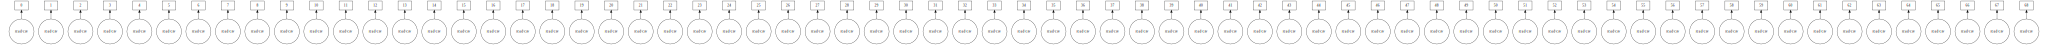

In [10]:
ddf.visualize(format='svg') # This visualization is very large, and using `format='svg'` will make it easier to view.

We can see that when we indicate for Dask to actually execute this operation, it will parallelize the work across the 4 GPUs in something like 69 parallel partitions. We can see the exact number of partitions with the `npartitions` property:

In [11]:
ddf.npartitions

69

The concept of constructing computational graphs with arbitrary operations before executing them is a core part of Dask. We will now add some more operations to the existing computational graph and visualize it again.

After executing the next cell we can see that the graph already constructed for `read_csv` now continues upward. It selects the `age` column across all partitions (visualized as `getitem`) and eventually performs the `.mean()` reduction (visualized as `series-sum-chunk`, `series-sum-agg`, `count-chunk`, `sum-agg` and `true-div`).

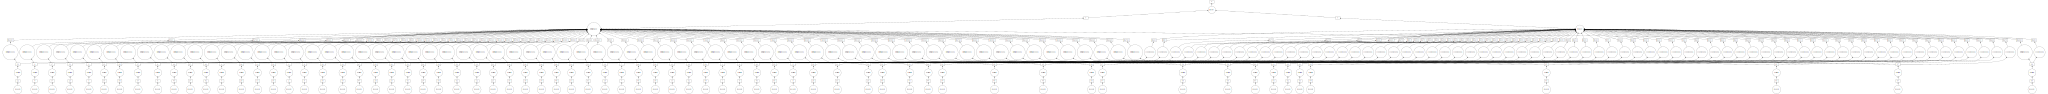

In [12]:
mean_age = ddf['age'].mean()
mean_age.visualize(format='svg')

### Computing with the Computational Graph

There are several ways to indicate to Dask that we would like to perform the computations described in the computational graphs we have constructed. Here we use the `.compute` method, which will return the output of the computation as an object in one GPU's memory - no longer distributed across GPUs.

Executing the following cell will send the computational graph we have created to the Dask scheduler to be executed in parallel on our 4 GPUs. Because our graph involves reading the entire 18GB dataset (as we declared when adding `read_csv` to the call graph), you can expect the operation to take a little time.

In [13]:
mean_age.compute()

40.124193580104645

### Persisting Data in the Cluster

The previous operation, which read the entire 18GB csv into the GPUs' memory, did not retain the data in memory after completing the computational graph:

In [14]:
!nvidia-smi

Thu Oct  7 14:15:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1B.0 Off |                    0 |
| N/A   32C    P0    32W /  70W |    795MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:1C.0 Off |                    0 |
| N/A   32C    P0    32W /  70W |    402MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

A typical Dask workflow, which we will utilize, is to persist data we would like to work with to the cluster and then perform fast operations on that persisted data. We do this with the `.persist` method.

In [15]:
ddf = ddf.persist()

We can see by executing `nvidia-smi` (after letting the `persist` finish), each GPU now has parts of the distributed dataframe in its memory:

In [16]:
!nvidia-smi

Thu Oct  7 14:15:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1B.0 Off |                    0 |
| N/A   33C    P0    36W /  70W |   1957MiB / 15109MiB |     70%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:1C.0 Off |                    0 |
| N/A   32C    P0    68W /  70W |    946MiB / 15109MiB |     69%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

Running `ddf.visualize` now shows that we no longer have operations in our task graph, only partitions of data, ready for us to perform operations:

In [17]:
ddf.visualize(format='svg')

Computing operations on this data will now be much faster:

In [18]:
ddf['age'].mean().compute()

40.124193580104645

The beauty of Dask is that working with your data, even though it is distributed and massive, is a lot like working with smaller in-memory datasets.

In [19]:
ddf.head() # As a convenience, no need to `.compute` the `head()` method

,age,sex,county,lat,long,name
0,0.0,m,Darlington,54.549641,-1.493884,HARRISON
1,0.0,m,Darlington,54.523945,-1.401142,LAKSH
2,0.0,m,Darlington,54.561127,-1.690068,MUHAMMAD
3,0.0,m,Darlington,54.542988,-1.543216,GRAYSON
4,0.0,m,Darlington,54.532101,-1.569116,FINLAY


In [20]:
ddf.count().compute()

age       292399470
sex       292399470
county    292399470
lat       292399470
long      292399470
name      292399470
dtype: int64

In [21]:
ddf.dtypes

age       float32
sex        object
county     object
lat       float32
long      float32
name       object
dtype: object

### Counties North of Sunderland with Dask

Here we perform the earlier task but on the distributed dataset. We identify the latitude of the northernmost resident of Sunderland county (the person with the maximum `lat` value), and then determine which counties have any residents north of this resident.

In [22]:
sunderland_residents = ddf.loc[ddf['county'] == 'Sunderland']
northmost_sunderland_lat = sunderland_residents['lat'].max()
counties_with_pop_north_of = ddf.loc[ddf['lat'] > northmost_sunderland_lat]['county'].unique()
counties_with_pop_north_of.compute()
counties_with_pop_north_of.head()

0          County Durham
1                Cumbria
2              Gateshead
3    Newcastle upon Tyne
4         North Tyneside
Name: county, dtype: object

## Grid Coordinate Conversion with Dask cuDF

Here we will work with Dask cuDF more by revisiting the user-defined grid conversion function to observe how Dask distributes the work of computational graphs and will continue preparing data for GPU-accelerated machine learning later

We create a Dask cluster before importing `dask_cudf` to ensure the latter has the right CUDA context. We will import the elements necessary for creating the Dask cluster and wait to import `dask_cudf` until after the cluster has been created.

In [3]:
import subprocess

from dask.distributed import Client, wait, progress
from dask_cuda import LocalCUDACluster

import dask.dataframe as dd

In [4]:
cmd = "hostname --all-ip-addresses"
process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
IPADDR = str(output.decode()).split()[0]

cluster = LocalCUDACluster(ip=IPADDR)
client = Client(cluster)
client

/opt/conda/envs/rapids/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36470 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://172.18.0.2:42442 Dashboard: http://172.18.0.2:36470/status,Cluster Workers: 4 Cores: 4 Memory: 186.82 GiB


Now we Import CUDA context creators after setting up the cluster so they don't lock to a single device.

In [5]:
import cudf
import dask_cudf

import cupy as cp

### Lat/Long to Grid Coordinate Conversion with Dask

We return again to converting latitude and longitude coordinates into grid coordinates by applying our custom `latlong2osgbgrid` function, however this time we will do so in a distributed fashion with Dask. Before we can do so, we need to discuss a little more specifically about how Dask distributes the computation of its task graphs.

Internally, Dask dataframes are split into a number of partitions, each being an individual cuDF dataframe. Under the hood, Dask automatically breaks up the work of dataframe methods and operations among these partitions, taking care to communicate efficiently and correctly. For this reason, in using Dask earlier today to perform Dask dataframe operations, you did not have to think explicitly about how Dask had partitioned the Dask dataframes.

However, when we would like to work with Dask dataframes outside their built-in methods and operators, such as when applying custom functions, we often need to work more explicitly with the partitions of the Dask dataframe, as we will do now.

### Dask Grid Converter

Ultimately, we are going to map our custom function to each partition of a Dask dataframe using the dataframe's `map_partitions` method.

With this in mind, let's look at `latlong2osgbgrid_dask`, noting modifications we have had to make to its CuPy counterpart in order to work effectively when mapped to Dask dataframe partitions rather than run on cuDF columns. There are 4 parts to the refactor, each with accompanying comments.

In [6]:
# 1) Rather than passing in `lat` and `long` arguments, we pass in a dataframe partition, specifying which columns hold latitude and longitude information.
def latlong2osgbgrid_dask(part_df, lat_col='lat', long_col='long', input_degrees=True):
    '''
    Converts latitude and longitude (ellipsoidal) coordinates into northing and easting (grid) coordinates, using a Transverse Mercator projection.
    
    Inputs:
    part_df: the dask distributed dataframe partition
    lat_col: the name of the column holding latitude data
    long_col: the name of the column holding longitude data
    input_degrees: if True (default), interprets the coordinates as degrees; otherwise, interprets coordinates as radians
    
    Output:
    original dataframe with northing and easting columns concatenated to the right
    '''
    
    # 2) Our previous function expected `lat` and `long` values to each be CuPy array-like, so we convert the relevant columns.
    lat = cp.asarray(part_df[lat_col])
    long = cp.asarray(part_df[long_col])
    
    # 3) At this point we reuse the previous cupy code until it is time to return values.
    if input_degrees:
        lat = lat * cp.pi/180
        long = long * cp.pi/180

    a = 6377563.396
    b = 6356256.909
    e2 = (a**2 - b**2) / a**2

    N0 = -100000 # northing of true origin
    E0 = 400000 # easting of true origin
    F0 = .9996012717 # scale factor on central meridian
    phi0 = 49 * cp.pi / 180 # latitude of true origin
    lambda0 = -2 * cp.pi / 180 # longitude of true origin and central meridian
    
    sinlat = cp.sin(lat)
    coslat = cp.cos(lat)
    tanlat = cp.tan(lat)
    
    latdiff = lat-phi0
    longdiff = long-lambda0

    n = (a-b) / (a+b)
    nu = a * F0 * (1 - e2 * sinlat ** 2) ** -.5
    rho = a * F0 * (1 - e2) * (1 - e2 * sinlat ** 2) ** -1.5
    eta2 = nu / rho - 1
    M = b * F0 * ((1 + n + 5/4 * (n**2 + n**3)) * latdiff - 
                  (3*(n+n**2) + 21/8 * n**3) * cp.sin(latdiff) * cp.cos(lat+phi0) +
                  15/8 * (n**2 + n**3) * cp.sin(2*(latdiff)) * cp.cos(2*(lat+phi0)) - 
                  35/24 * n**3 * cp.sin(3*(latdiff)) * cp.cos(3*(lat+phi0)))
    I = M + N0
    II = nu/2 * sinlat * coslat
    III = nu/24 * sinlat * coslat ** 3 * (5 - tanlat ** 2 + 9 * eta2)
    IIIA = nu/720 * sinlat * coslat ** 5 * (61-58 * tanlat**2 + tanlat**4)
    IV = nu * coslat
    V = nu / 6 * coslat**3 * (nu/rho - cp.tan(lat)**2)
    VI = nu / 120 * coslat ** 5 * (5 - 18 * tanlat**2 + tanlat**4 + 14 * eta2 - 58 * tanlat**2 * eta2)

    northing = I + II * longdiff**2 + III * longdiff**4 + IIIA * longdiff**6
    easting = E0 + IV * longdiff + V * longdiff**3 + VI * longdiff**5
    
    # 4) Having calculated `northing` and `easting`, we add them as series to our partition and then return the partition.
    part_df['northing'] = cudf.Series(northing)
    part_df['easting'] = cudf.Series(easting)
    
    return(part_df)

### Mapping Functions to Partitions

The Dask dataframe `map_partitions` method applies a given function to each partition. As you saw in the `latlong2osgbgrid_dask` function, at least one of the arguments to the function should be a `dask.dataframe` (in our case, `part_df`).

The other requirement for `map_partitions` is a *meta*: a dataframe with the structure that we will be returning from the function. You can think of this like defining a function signature, and in fact, you will find many instances in Dask programming where a meta is required.

In our case, however, Dask can automatically infer the meta from our function and its inputs, so we don't need to provide one explicitly.

### Using the Parquet Format

The csv format we have using thus far has been realistic to many data scientists' experiences, but alternatives are often more efficient for our needs.

Here, we will output to the columnar Apache Parquet format, a natural companion to the Apache Arrow memory format of RAPIDS. Parquet also will compress our data from about 18Gb to about 12Gb. 

The `to_parquet` writer will create a folder of smaller parquet files with associated metadata that can efficiently be read back in later with `read_parquet`, taking advantage of parallel I/O with multiple GPU workers in Dask.

### Building a Dask Grid Converter Pipeline

We can now build a simple data pipeline to add OSGB36 grid coordinates to the population dataset. This will consist of three steps:

1. Read the csv file at `./data/pop5x_1-07.csv` into a Dask dataframe with `read_csv`
2. Map the function `latlong2osgbgrid_dask` over that dataframe with `map_partitions`
3. Write the results to the parquet format in the folder `pop5x` with `to_parquet`

In [7]:
ddf = dask_cudf.read_csv('./data/pop5x_1-07.csv')
ddf = ddf.map_partitions(latlong2osgbgrid_dask)
ddf.to_parquet('pop5x')

### Computing Grid Coordinate Statistics

We can analyze the results of mapping `latlong2osgbgrid_dask` the same way as any other `dask_cudf` dataframe columns. We can also see the speed enabled by parquet in the following two steps:

1. Read the `pop5x` folder of parquet files into a Dask dataframe
2. Compute the mean of the `northing` and `easting` columns

In [9]:
ddf = dask_cudf.read_parquet('pop5x')
ddf[['northing', 'easting']].mean().compute()

northing    273564.672821
easting     447839.348862
dtype: float64